# Double integration

In [25]:
%matplotlib notebook
from speed_regression import training_data as td
from speed_regression import imu_optimization as imu_optimization
import numpy as np
import pandas
import sklearn.svm as svm
from sklearn.externals import joblib
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import quaternion

import algorithms.double_integration as double_integration
from utility.write_trajectory_to_ply import write_ply_to_file

nano_to_sec = 1e09

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

## Test linear acceleration signal

<IPython.core.display.Javascript object>


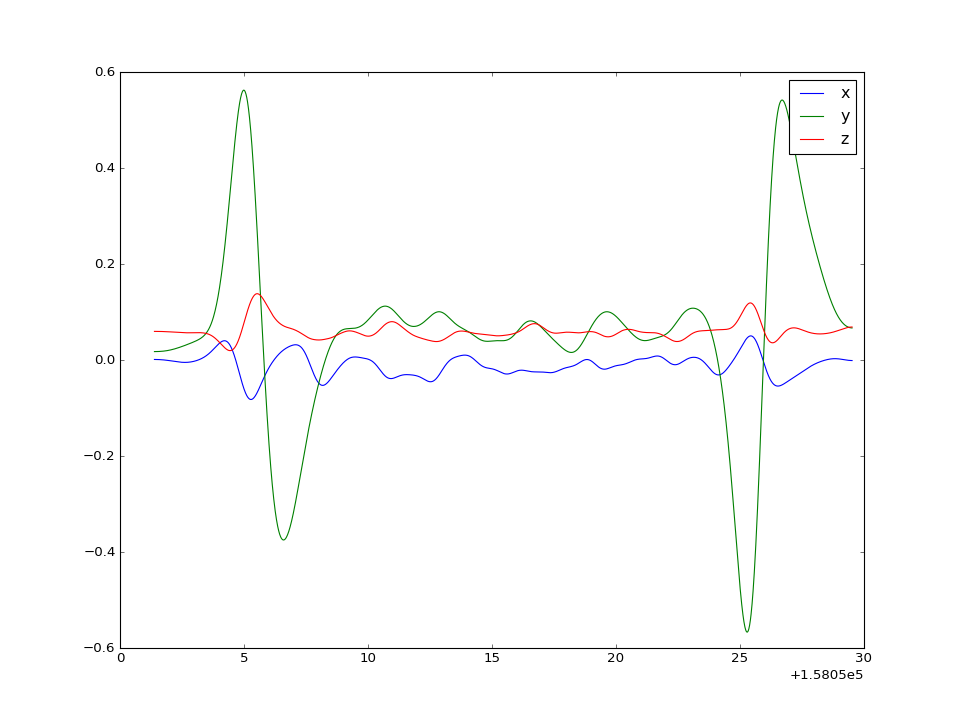

<IPython.core.display.Javascript object>


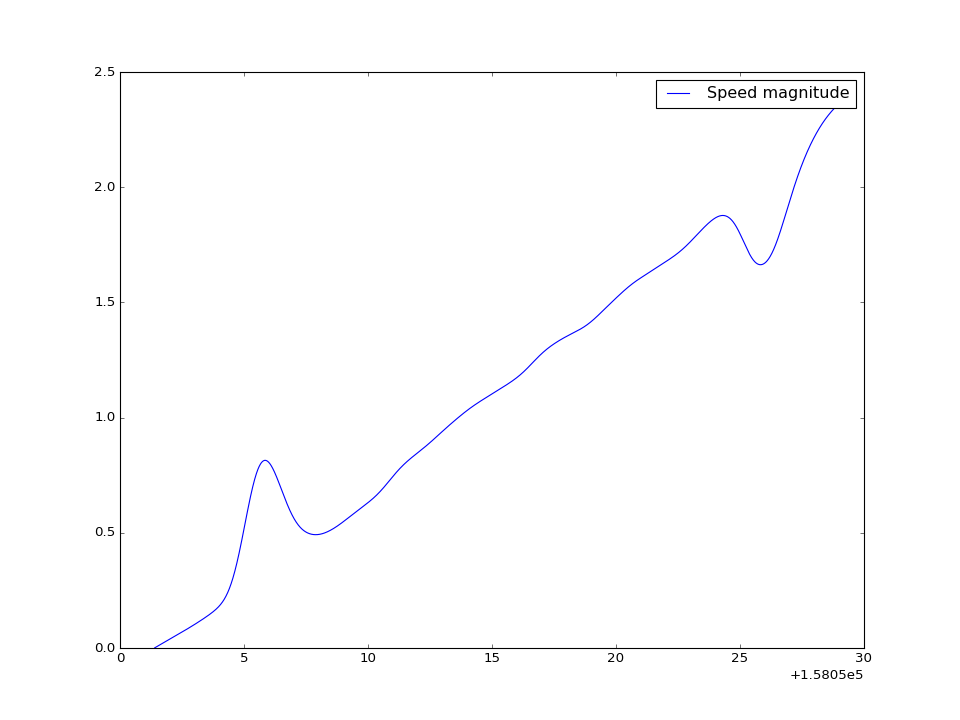

In [2]:
test_data_all = pandas.read_csv('../../data/test_line1/processed/data.csv')
linacce = test_data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
time_stamp = test_data_all['time'].values / nano_to_sec
orientation = test_data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values
    
time_interval = (time_stamp[1:] - time_stamp[:-1])[:, None]
directed_raw_acce = np.empty(linacce.shape, dtype=float)
for i in range(linacce.shape[0]):
    rot = quaternion.as_rotation_matrix(quaternion.quaternion(*orientation[i]))
    directed_raw_acce[i] = np.dot(rot, linacce[i].transpose()).flatten()

directed_raw_acce = gaussian_filter1d(directed_raw_acce, sigma=50.0, axis=0)

plt.figure('Raw acceleration')
plt.plot(time_stamp, directed_raw_acce)
plt.legend(list('xyz'))

raw_speed = np.cumsum((directed_raw_acce[1:] + directed_raw_acce[:-1]) * time_interval / 2.0, axis=0)

plt.figure('Accumulated speed')
plt.plot(time_stamp[1:], np.linalg.norm(raw_speed, axis=1))
plt.legend(['Speed magnitude'])

# IMU Calibration

## IMU Optimization

<IPython.core.display.Javascript object>


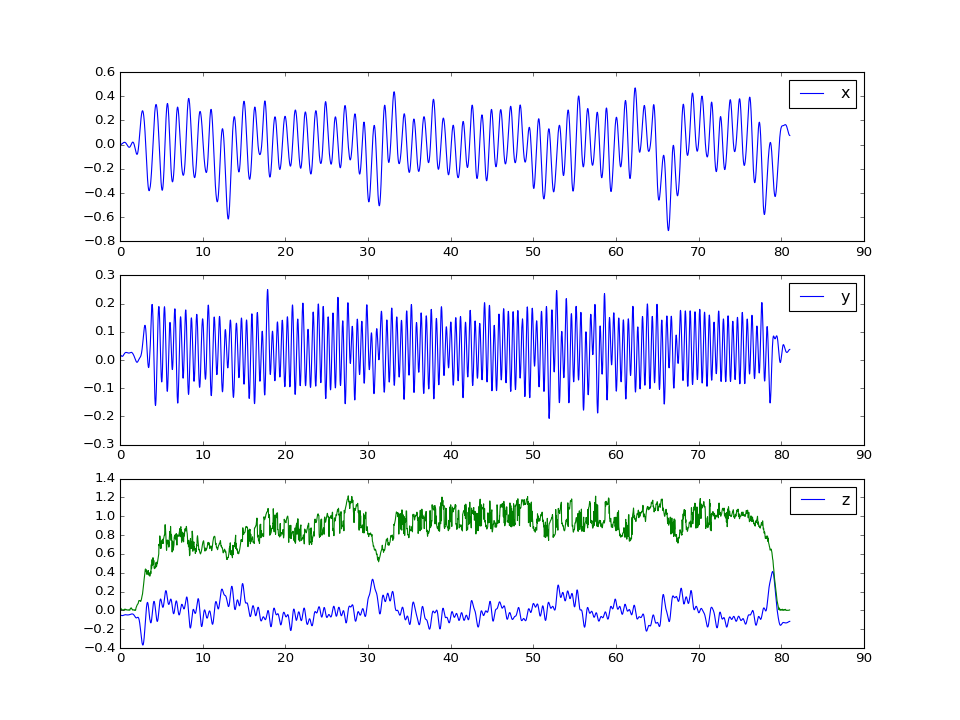

<IPython.core.display.Javascript object>


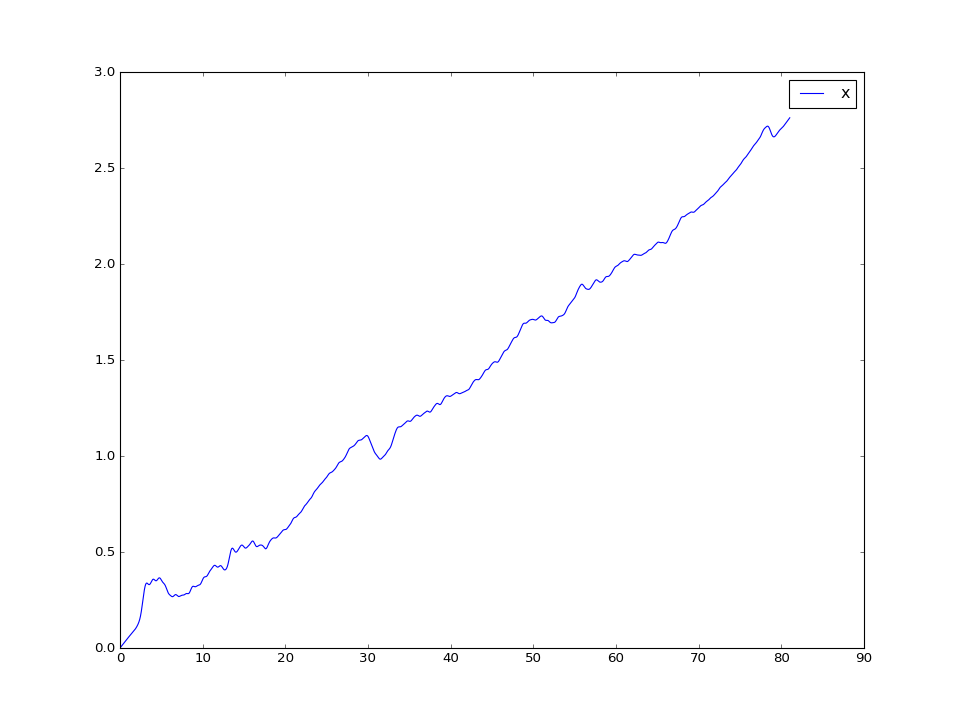

In [11]:
data_all = pandas.read_csv('../../data/20170126025407/processed/data.csv')
time_stamp = data_all['time'].values / nano_to_sec
time_stamp -= time_stamp[0]
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']
options = td.TrainingDataOption(feature='fourier', window_size=200, frq_threshold=100, sample_step=50)
speed_ind = np.arange(options.window_size_, data_all.shape[0] - 1, options.sample_step_, dtype=int)

filter_sigma = 20.0

linacce = data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values

filtered_acce = gaussian_filter1d(linacce, sigma=filter_sigma, axis=0)

axis_legend = 'xyz'
plt.figure('Raw acceleration')
plt.title('Raw Acceleration')    
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, filtered_acce[:, i])
    plt.legend(axis_legend[i])
    
time_interval = (time_stamp[1:] - time_stamp[:-1])[:, None]
directed_raw_acce = np.empty(linacce.shape, dtype=float)
for i in range(linacce.shape[0]):
    rot = quaternion.as_rotation_matrix(quaternion.quaternion(*orientation[i]))
    directed_raw_acce[i] = np.dot(rot, filtered_acce[i].transpose()).flatten()

directed_raw_acce = gaussian_filter1d(directed_raw_acce, sigma=filter_sigma, axis=0)

raw_speed = np.cumsum((directed_raw_acce[1:] + directed_raw_acce[:-1]) * time_interval / 2.0, axis=0)
plt.figure('Accumulated speed')
plt.plot(time_stamp[1:], np.linalg.norm(raw_speed, axis=1))
plt.legend(['x', 'y', 'z'])

Optimizing acceleration bias
`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 2.1939e+00, final cost 6.6897e-02, first-order optimality 2.18e-05.


<IPython.core.display.Javascript object>


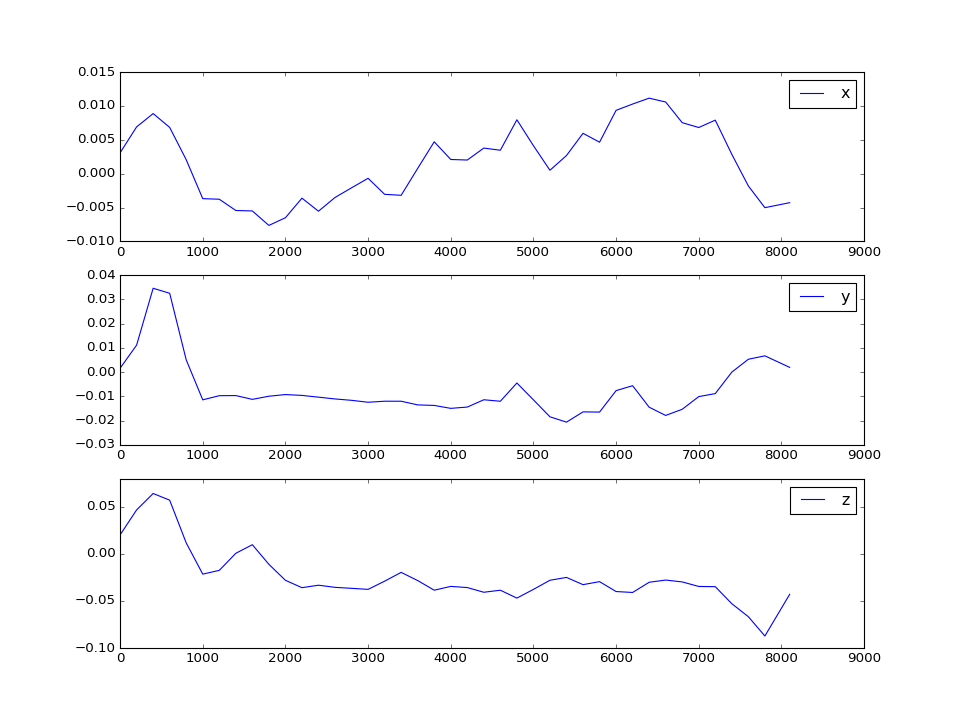

<IPython.core.display.Javascript object>


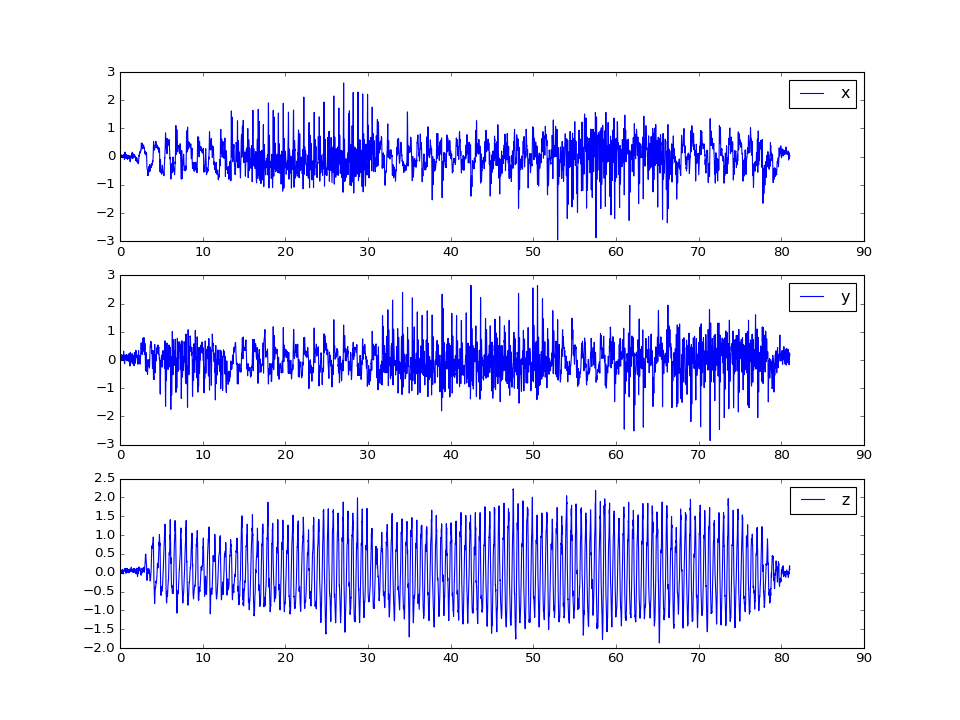

<IPython.core.display.Javascript object>


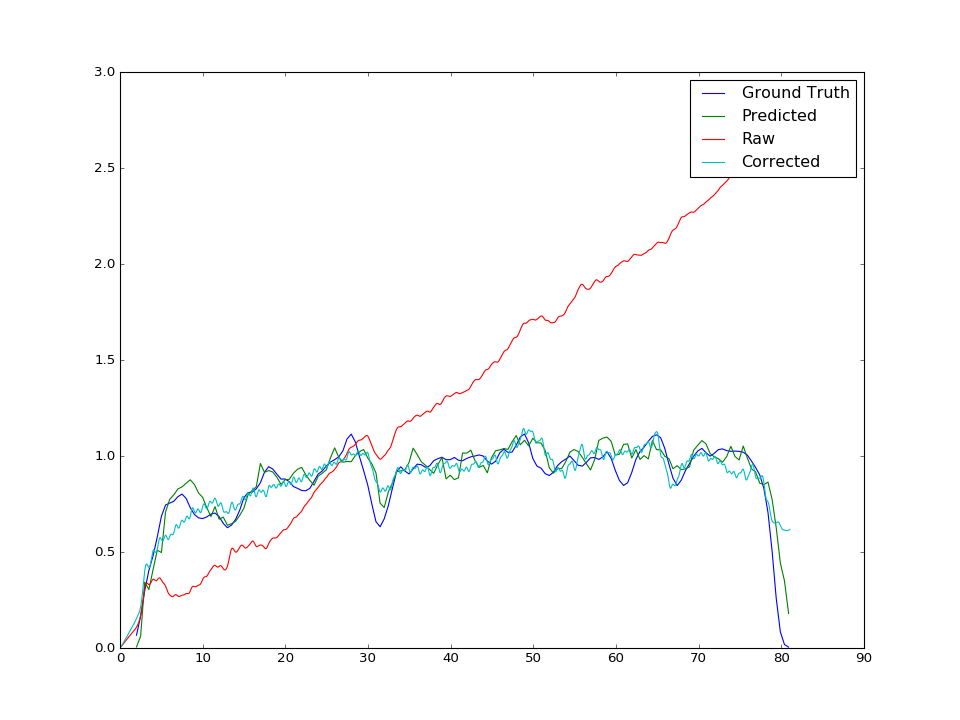

In [10]:
test_data = td.get_training_data(data_all=data_all, imu_columns=imu_columns,
                                 option=options, sample_points=speed_ind)
regressor = joblib.load('../../models/model_walk_fourier_w200_s10.svm')
predicted_speed = regressor.predict(test_data[:, :-1])

param = {'sigma_a': 0.1, 'sigma_s': 0.2}

variable_ind = np.arange(1, linacce.shape[0], 200, dtype=int)
variable_ind[-1] = speed_ind[-1] + 1

print('Optimizing acceleration bias')
optimizer, corrected = imu_optimization.optimize_linear_acceleration(time_stamp=time_stamp,
                                                                     linacce=linacce,
                                                                     orientation=orientation,
                                                                     speed_ind=speed_ind,
                                                                     sparse_location=variable_ind,
                                                                     method='speed_magnitude',
                                                                     regressed_speed=predicted_speed,
                                                                     param=param,
                                                                     verbose=1)

bias = optimizer.x.reshape([-1, 3])
plt.figure('Bias') 
plt.title('Estimated Bias')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(variable_ind, bias[:, i])
    plt.legend(axis_legend[i])

plt.figure('Corrected acceleration')
plt.title('Corrected acceleration')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, corrected[:, i])
    plt.legend(axis_legend[i])
    
# corrected acceleration is already inside the global frame, no need for transformation
corrected = gaussian_filter1d(corrected, sigma=filter_sigma, axis=0)

speed_corrected = np.cumsum((corrected[1:] + corrected[:-1]) * time_interval / 2.0, axis=0)

plt.figure('Speed optmization')
plt.plot(time_stamp[speed_ind], test_data[:, -1])
plt.plot(time_stamp[speed_ind], predicted_speed)
plt.plot(time_stamp[1:], np.linalg.norm(raw_speed, axis=1))
plt.plot(time_stamp[1:], np.linalg.norm(speed_corrected, axis=1))
plt.legend(['Ground Truth', 'Predicted', 'Raw', 'Corrected'])

### Experiment: drop the z direction

(8113,)


<IPython.core.display.Javascript object>


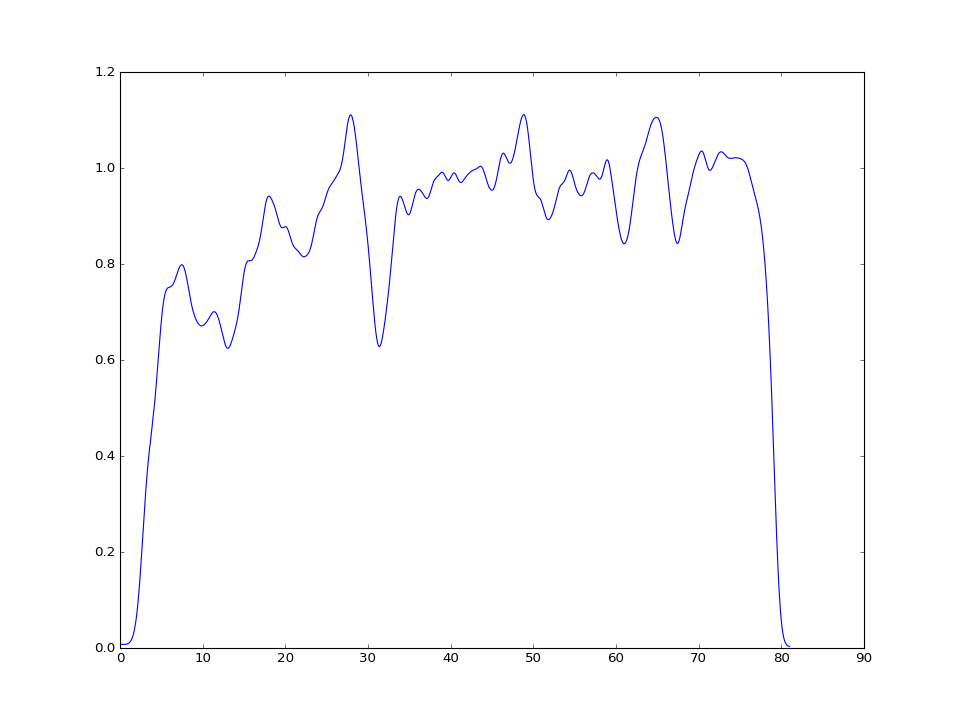

In [24]:
# Evaluate two cells before

# Compute xy speed
speed_sigma = 50.0
pose_xy = data_all[['pos_x', 'pos_y']].values
speed_xy = np.linalg.norm((pose_xy[2:] - pose_xy[:-2]) / (time_stamp[2:] - time_stamp[:-2])[:, None], axis=1)

directed_acce = np.empty(linacce.shape, dtyoe=float)
for i in range(directed_acce.shape[0]):
    rot = quaternion.as_rotation_matrix(quaternion.quaternion(*orientation[i]))
    directed_acce[i] = np.dot(rot, linacce[i].transpose()).flatten()

speedxy_functor = imu_optimization.SpeedMagnitudeFunctor(time_stamp=time_stamp,
                                                        linacce=directed_acce[:, :2],
                                                        target_speed=speed_xy[speed_ind],
                                                        speed_ind=speed_ind,
                                                        variable_ind=variable_ind,
                                                        sigma_a=0.1,
                                                        sigma_s=0.5)
print('Optimizing')
optimizer = least_squares(speedxy_functor, jac='3-point', max_nfev=200, verbose=2)

corrected = np.copy(directed_acce)
corrected[:variable_ind[-1]] = speedxy_functor.correct_acceleration(corrected[:sparse_location[-1]],
                                                                   optimizer.x.reshape([-1, 2]))

# plot the result
speed_xy = np.insert(speed_xy, [0, -1], [0., 0.])
speed_xy = gaussian_filter1d(speed_xy, sigma=speed_sigma, axis=0)
plt.figure('XY speed')
plt.plot(time_stamp, speed_xy)